In [1]:
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));
cs2 = ColorScheme(range(colorant"red", colorant"royalblue1", length=7));
cs3 = ColorScheme(range(colorant"red", colorant"darkblue", length=10));

#using QuadGK
#using Profile, ProfileSVG

#using Base.Threads: @threads, @spawn
#ENV["JULIA_NUM_THREADS"]

using DelimitedFiles

using Distributions, Random

#using JLD2, FileIO

const e_charge = 1.60217663E-19 
const r_e = 2.8179402895E-15
const mec2 = 510998.94999999995

510998.94999999995

# Lattice Parameters 
#### (Choose one set to load)

In [2]:
# FACET-II  parameters

L_bend = 20.0
L_drift_side = 32.5
L_drift_middle = 32.5

rho = 1538.0
phi_m = L_bend/rho
gamma = 30e9/mec2
beta = (1-1/gamma^2)^(1/2)
p0c = gamma * beta * mec2;

sig_z = 40e-6

L0 = (24*sig_z*rho^2)^(1/3)

13.144012637628592

In [2]:
# LCLS2 BC2 parameters

L_bend = 0.54920085
L_drift_side = 9.871029
L_drift_middle = 1.75

rho = 11.723475
phi_m = 0.046846251
gamma = 1.5e9/mec2
beta = (1-1/gamma^2)^(1/2)
p0c = gamma * beta * mec2

#L0 = (24*0.00029789116477357526*rho^2)^(1/3)

0.9941697148357627

In [7]:
# Yunhai lattice parameters

#rho = 1.5
#gamma = 10000.0
#phi_m = 0.2

#beta = (1-1/gamma^2)^(1/2)

#lamb = 0.01/rho

# const phi_m = 0.5/rho

#sigma_z = 50e-6
#sigma_x = 50e-6

#p0c = gamma * beta * mec2

#L0 = (24*sigma_z*rho^2)^(1/3)

# Beam definition
#### Choose one beam to load, or define your own beam

In [22]:
# Artificial Gaussian beam for benchmarking

using Distributions, Random
Random.seed!(1234)  # Fix random seed

Np = 1000000
Q = 5E-9

charges = ones(Np)*Q/Np;

bb = Array{Float64, 2}(undef, 6, Np);


bb[1,1:Np] = rand(Normal(0, 50E-6), Np);
bb[2,1:Np] = rand(Normal(0, 50E-6), Np);
bb[3,1:Np] = rand(Normal(0, 50E-6), Np);
bb[4,1:Np] = rand(Normal(0, 50E-6), Np);
bb[5,1:Np] = rand(Normal(0, 50E-6), Np);
bb[6,1:Np] = rand(Normal(0, 1E-6), Np);

zmin = minimum(bb[5,:])
zmax = maximum(bb[5,:])
xmin = minimum(bb[1,:])
xmax = maximum(bb[1,:])

0.0002666613359011983

In [3]:
#writedlm("beam_5M_Gauss", bb)

In [5]:
# Astra beam (Np = 2M) for LCLS-II, tracked from BEAM0 to BC2BCBEG in sc_hxr by Bmad 
beam_dat = readdlm("BC2_chicane_tracking/beam_no_header.dat");

bb = beam_dat[:,1:6]'; #Remember to transpose!
charges = beam_dat[:,7]

Np = length( beam_dat[:,7])
Q = sum(charges)

zmin = minimum(bb[5,:])
zmax = maximum(bb[5,:])
xmin = minimum(bb[1,:])
xmax = maximum(bb[1,:])

# Check bunch length
sig_z = std(bb[5,:])

Nb = Q/e_charge

# Check characteristic CSR strength ( in 1/m^2 )
W0 = Nb* r_e * mec2 *(sig_z/abs(rho))^(2/3) / sig_z^2

339.04192018800615

In [3]:
# FACET-II beam (Np = 1M) from Glen White

beam_dat = readdlm("FACET_chicane_tracking/FACET_beam_in.dat");
#charges_dat = readdlm("FACET_chicane_tracking/FACET_beam_in_charges.dat");

bb = beam_dat';
#charges = charges_dat;

Np = 1000000
Q = 2E-9

charges = ones(Np)*Q/Np;

# Check bunch length
sig_z = std(bb[5,:])

Nb = Q/e_charge

# Check characteristic CSR strength ( in 1/m^2 )
W0 = Nb* r_e * mec2 *(sig_z/abs(rho))^(2/3) / sig_z^2

98669.00574412545

# Wake check

In [4]:
include("core/kick2.jl")

csr2d_kick_calc_exit (generic function with 1 method)

In [5]:
r_ent = csr2d_kick_calc_entrance(bb[5,:], bb[1,:], charges,
    gamma=gamma, rho=rho, phi=0.01,
    nz=201, nx=101, nxp=301, M=7)

 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 15.555075 seconds (1.28 M CPU allocations: 76.565 MiB, 0.21% gc time)
 14.317164 seconds (112 CPU allocations: 5.688 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000190797, stop=0.000187454, length=201)
  "ddelta_ds"   => [-1.93844e-6, -1.59819e-6, -1.33495e-6, -1.4199e-6, -1.87665…
  "Ws_grid"     => [-4.36529 -4.12831 … 20.8297 21.0835; -3.69563 -3.41332 … 21…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "xv"          => range(-0.000635789, stop=0.000586946, length=101)
  "Wx_grid"     => [1.90406 1.78455 … 3.58362 3.58207; 1.94755 1.82694 … 3.6227…
  "dxp_ds"      => [2.94934e-8, 2.01758e-8, 2.22632e-8, 1.91911e-8, 2.1404e-8, …

In [7]:
r_ent2 = csr2d_kick_calc_entrance(bb[5,:], bb[1,:], charges,
    gamma=gamma, rho=rho, phi=0.04,
    nz=201, nx=101, nxp=301, M=8, reverse_bend=true)

 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 26.600114 seconds (1.29 M CPU allocations: 76.810 MiB, 0.08% gc time)
 25.552258 seconds (6.82 k CPU allocations: 398.615 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000190797, stop=0.000187454, length=201)
  "ddelta_ds"   => [-1.91343e-6, -1.64769e-6, -1.19469e-6, -1.43422e-6, -1.9342…
  "Ws_grid"     => [-4.6909 -4.48145 … 20.9629 21.2216; -3.67276 -3.39633 … 21.…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [1.90029 1.77952 … 3.58313 3.58249; 1.94274 1.82103 … 3.6233…
  "xv"          => range(-0.000586946, stop=0.000635789, length=101)
  "dxp_ds"      => [-2.44516e-8, -2.40497e-8, -1.58427e-8, -2.02199e-8, -3.0866…

In [31]:
r_exit1 = csr2d_kick_calc_exit(bb[5,:], bb[1,:], charges,
    gamma=gamma, rho=rho, phi_m=phi_m, lamb=0.01,
    nz=101, nx=51, nxp=101, M=7, reverse_bend = true)

 Applying charge deposition...
 Computing Case C+D+E wake grid(s) via GPU...
  6.975900 seconds (305.76 k CPU allocations: 16.750 MiB)
  6.809312 seconds (109 CPU allocations: 5.391 KiB)
 Interpolating wake value at the particle positions...


Dict{String, AbstractArray{Float64}} with 7 entries:
  "zv"          => range(-0.000190797, stop=0.000187454, length=101)
  "ddelta_ds"   => [-5.99555e-7, -4.30279e-7, -3.28504e-7, -3.69663e-7, -5.2146…
  "Ws_grid"     => [-0.00621812 -0.00546619 … -0.0524089 -0.0494394; -0.0474094…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [2.07627e-8 1.1113e-8 … -1.43505e-6 -1.48006e-6; 2.90388e-7 …
  "xv"          => range(-0.000586946, stop=0.000635789, length=51)
  "dxp_ds"      => [-3.59687e-11, -1.66351e-11, -6.2457e-12, -1.22184e-11, -2.3…

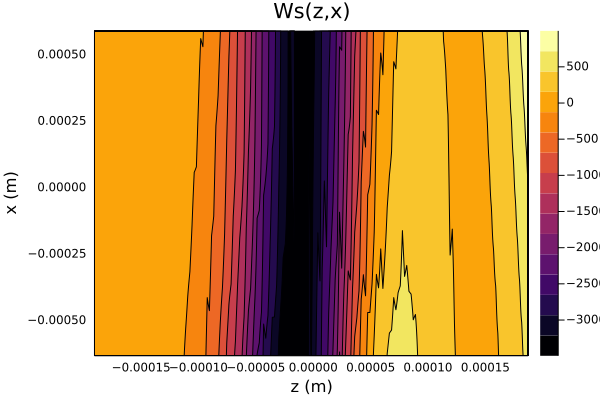

In [6]:
contourf(r_ent["zv"], r_ent["xv"], r_ent["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

# Tracking

In [15]:
include("core/simple_track.jl")

track_a_drift (generic function with 1 method)

In [17]:
function emit(bb)
    return sqrt(cov(bb[1,:], bb[1,:])*cov(bb[2,:], bb[2,:]) - cov(bb[1,:], bb[2,:])^2)
end

emit (generic function with 1 method)

In [16]:
function emit_dispersion_free(bb)
    delta2 = cov(bb[6,:], bb[6,:])
    xd = cov(bb[1,:], bb[6,:])
    pd = cov(bb[2,:], bb[6,:])
    
    eb = cov(bb[1,:], bb[1,:]) - xd^2 / delta2
    eg = cov(bb[2,:], bb[2,:]) - pd^2 / delta2
    ea = -cov(bb[1,:], bb[2,:]) + xd * pd / delta2
    
    emit = sqrt(eb*eg - ea^2)
    return emit 
end

emit_dispersion_free (generic function with 1 method)

In [49]:
emit_dispersion_free(bb)

2.5587975641713083e-10

In [18]:
function track_bend_with_2d_csr!(beam, charges, p0c, gamma; L=0, rho=1.0, 
                            N_step=20, s0=0.0, nz=201, nx=101, nxp=301, M=7, reverse_bend=false,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            bend_name="the bend", keep_Pin=false, debug=true, save_all_P=false)
    
    #rho = 1/g  
    #beam, charges = particle_group_to_bmad(Pin, p0c = p0c)
    if keep_Pin
        beam_list = [beam]
        slist = [s0]
        emit_list = [emit(beam)]
        emit_disp_free_list = [emit_dispersion_free(beam)]
    else
        beam_list = []
        slist = []
        emit_list = []
        emit_disp_free_list = []    
    end
    
    Ws_list = Matrix{Float64}[]
    Wx_list = Matrix{Float64}[]
    
    s = s0
    ds_step = L/N_step
    phi = 0
    
    theta = ds_step/2/rho
    if reverse_bend
        theta = -theta
    end

    for i in 1:N_step
        println("Tracking through ", bend_name, " in the ", i, "th step starting at s= " , s,'m' ) 

        ## track through a bend of length ds/2
        #beam = track(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
        
        temp = [track_a_bend(beam[:,i], p0c, L=ds_step/2, theta=theta) for i in 1:Np]
        beam = reduce(hcat,temp)
        phi += ds_step/2/rho
        
        ## Calculate CSR kicks to xp and delta
        ####===================================
    
        if (CSR_on)
            
            if (CSR_1D_only)
                println("Applying 1D s-s kick...")
                #csr_data = csr1d_steady_state_kick_calc(beam[4,:], charges, nz=nz, rho=rho, normalized_units=False)
                #delta_kick = csr_data['denergy_ds']/(gamma*mec2)
                #beam[6] = beam[6] + delta_kick * ds_step
                
            else
                
                csr_data = csr2d_kick_calc_entrance(beam[5,:], beam[1,:], charges,
                            gamma=gamma, rho=rho, phi=phi,
                            nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=reverse_bend)
                
                if (energy_kick_on)
                    println("Applying energy kick...")
                    delta_kick = csr_data["ddelta_ds"]
                    beam[6,:] = beam[6,:] .+ delta_kick * ds_step
                end
                
                if (xp_kick_on)
                    println("Applying xp_kick...")
                    xp_kick = csr_data["dxp_ds"]
                    beam[2,:] = beam[2,:] .+ xp_kick * ds_step
                end
            end
        end
    
        ####====================================

        ## track through a bend of length ds/2
        temp = [track_a_bend(beam[:,i], p0c, L=ds_step/2, theta=theta) for i in 1:Np]
        beam = reduce(hcat,temp)
        phi += ds_step/2/rho
    
        s += ds_step
        append!(slist, s)
        append!(emit_list, emit(beam))
        append!(emit_disp_free_list, emit_dispersion_free(beam))
        
        # This might take memory
        if save_all_P
            push!(beam_list, beam)
        end
        if CSR_on && !CSR_1D_only
            push!(Ws_list, csr_data["Ws_grid"])
            push!(Wx_list, csr_data["Wx_grid"])
        end
    end
    
    
    dd = Dict("beam_out" => beam, "s_list" => slist, 
        "emit_list" => emit_list, "emit_disp_free_list" => emit_disp_free_list,
        "beam_list" => beam_list, "Ws_list"=>Ws_list, "Wx_list"=>Wx_list)
    
    return dd
end

track_bend_with_2d_csr! (generic function with 1 method)

In [27]:
function track_drift_with_2d_csr!(beam, charges, p0c, gamma; L=0, rho=1.0, phi_m=0.0, 
                            N_step=20, s0=0.0, nz=201, nx=101, nxp=301, M=7, reverse_bend=false,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            drift_name="the drift", keep_Pin=false, debug=true, save_all_P=false)
    
    #rho = 1/g  
    #beam, charges = particle_group_to_bmad(Pin, p0c = p0c)

    if keep_Pin
        beam_list = [beam]
        slist = [s0]
        emit_list = [emit(beam)]
        emit_disp_free_list = [emit_dispersion_free(beam)]
    else
        beam_list = []
        slist = []
        emit_list = []
        emit_disp_free_list = []    
    end
    
    Ws_list = Matrix{Float64}[]
    Wx_list = Matrix{Float64}[]  
    
    
    s = s0
    ds_step = L/N_step
    lamb = 0

    for i in 1:N_step
        println("Tracking through ", drift_name, " in the ", i, "th step starting at s= " , s,'m' ) 
        
        temp = [track_a_drift(beam[:,i], p0c, L=ds_step/2) for i in 1:Np]
        beam = reduce(hcat,temp)
        lamb += ds_step/2/rho
        
        ## Calculate CSR kicks to xp and delta
        ####===================================
    
        if (CSR_on)
            
            if (CSR_1D_only)
                println("Applying 1D s-s kick... ( to be implemented )")
                #csr_data = csr1d_steady_state_kick_calc(beam[4,:], charges, nz=nz, rho=rho, normalized_units=False)
                #delta_kick = csr_data['denergy_ds']/(gamma*mec2)
                #beam[6] = beam[6] + delta_kick * ds_step
                
            else
                  csr_data = csr2d_kick_calc_exit(beam[5,:], beam[1,:], charges,
                            gamma=gamma, rho=rho, phi_m=phi_m, lamb=lamb,
                            nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=reverse_bend)  
                
                if (energy_kick_on)
                    println("Applying energy kick...")
                    delta_kick = csr_data["ddelta_ds"]
                    beam[6,:] = beam[6,:] .+ delta_kick * ds_step
                end
                
                if (xp_kick_on)
                    println("Applying xp_kick...")
                    xp_kick = csr_data["dxp_ds"]
                    beam[2,:] = beam[2,:] .+ xp_kick * ds_step
                end
            end
        end
    
        ####====================================

        ## track through a bend of length ds/2
        temp = [track_a_drift(beam[:,i], p0c, L=ds_step/2) for i in 1:Np]
        beam = reduce(hcat,temp)
        lamb += ds_step/2/rho
    
        s += ds_step
        append!(slist, s)
        append!(emit_list, emit(beam))
        append!(emit_disp_free_list, emit_dispersion_free(beam))
        
        # This might take memory
        if save_all_P
            push!(beam_list, beam)
        end
        if CSR_on && !CSR_1D_only
        push!(Ws_list, csr_data["Ws_grid"])
        push!(Wx_list, csr_data["Wx_grid"])
        end
    end
    
    
    dd = Dict("beam_out" => beam, "s_list" => slist, 
        "emit_list" => emit_list, "emit_disp_free_list" => emit_disp_free_list,
        "beam_list" => beam_list, "Ws_list"=>Ws_list, "Wx_list"=>Wx_list)
    
    return dd
end

track_drift_with_2d_csr! (generic function with 1 method)

In [20]:
function track_chicane_with_2d_csr!(beam, charges, p0c, gamma; 
                            s0=0, rho=0, phi_m=0,
                            L_bend=0, N_step_bend=20, 
                            L_drift_side=0, N_step_drift_side=20,
                            L_drift_middle=0, N_step_drift_middle=20,
                            nz=201, nx=201, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin=true, debug=true, save_all_P=false)
    
    println("Begin tracking through BEND #1...")
    out1 = track_bend_with_2d_csr!(beam, charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s0, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B1", keep_Pin=keep_Pin, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #1...")
    s=s0+L_bend
    out2 = track_drift_with_2d_csr!(out1["beam_out"], charges, p0c, gamma; L=L_drift_side, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_side, s0=s, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D1", keep_Pin=false, debug=debug, save_all_P=save_all_P)

    println("Begin tracking through BEND #2...")
    s=s+L_drift_side
    out3 = track_bend_with_2d_csr!(out2["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B2", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #2...")
    s=s+L_bend
    out4 = track_drift_with_2d_csr!(out3["beam_out"], charges, p0c, gamma; L=L_drift_middle, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_middle, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D2", keep_Pin=false, debug=debug, save_all_P=save_all_P)
 
    println("Begin tracking through BEND #3...")
    s=s+L_drift_middle
    out5 = track_bend_with_2d_csr!(out4["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B3", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #3...")
    s=s+L_bend
    out6 = track_drift_with_2d_csr!(out5["beam_out"], charges, p0c, gamma; L=L_drift_side, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_side, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D3", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through BEND #4...")
    s=s+L_drift_side
    out7 = track_bend_with_2d_csr!(out6["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B4", keep_Pin=false, debug=debug, save_all_P=save_all_P)    
    
    println("Tracking finished!!!")


    s1 = out1["s_list"]
    s2 = out2["s_list"]
    s3 = out3["s_list"]
    s4 = out4["s_list"]
    s5 = out5["s_list"]
    s6 = out6["s_list"]
    s7 = out7["s_list"]
    
    emdf1 = out1["emit_disp_free_list"]
    emdf2 = out2["emit_disp_free_list"]
    emdf3 = out3["emit_disp_free_list"]
    emdf4 = out4["emit_disp_free_list"]
    emdf5 = out5["emit_disp_free_list"]
    emdf6 = out6["emit_disp_free_list"]
    emdf7 = out7["emit_disp_free_list"]
    
    em1 = out1["emit_list"]
    em2 = out2["emit_list"]
    em3 = out3["emit_list"]
    em4 = out4["emit_list"]
    em5 = out5["emit_list"]
    em6 = out6["emit_list"]
    em7 = out7["emit_list"]
    
    s_list = vcat(s1, s2, s3, s4, s5, s6, s7)
    em_list = vcat(em1, em2, em3, em4, em5, em6, em7)
    emdf_list = vcat(emdf1, emdf2, emdf3, emdf4, emdf5, emdf6, emdf7)
    
    #Plist = out1['Plist'] + out2['Plist'] + out3['Plist'] + out4['Plist'] + out5['Plist'] + out6['Plist'] + out7['Plist']
    #output['Plist'] = Plist

    output = Dict( "s_list" => s_list, "em_list"=> em_list, "emdf_list"=> emdf_list,
    "beam_out_B1" => out1["beam_out"],
    "beam_out_D1" => out2["beam_out"],
    "beam_out_B2" => out3["beam_out"],
    "beam_out_D2" => out4["beam_out"],
    "beam_out_B3" => out5["beam_out"],
    "beam_out_D3" => out6["beam_out"],
    "beam_out_B4" => out7["beam_out"],
    "Ws_list_B1" => out1["Ws_list"],
    "Ws_list_D1" => out2["Ws_list"],
    "Ws_list_B2" => out3["Ws_list"],
    "Ws_list_D2" => out4["Ws_list"],
    "Ws_list_B3" => out5["Ws_list"],
    "Ws_list_D3" => out6["Ws_list"],
    "Ws_list_B4" => out7["Ws_list"])
    
    
    return output
end

track_chicane_with_2d_csr! (generic function with 1 method)

In [32]:
function track_chicane_with_2d_csr_no_exit!(beam, charges, p0c, gamma; 
                            s0=0, rho=0, phi_m=0,
                            L_bend=0, N_step_bend=20, 
                            L_drift_side=0, N_step_drift_side=20,
                            L_drift_middle=0, N_step_drift_middle=20,
                            nz=201, nx=201, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin=true, debug=true, save_all_P=false)
    
    println("Begin tracking through BEND #1...")
    out1 = track_bend_with_2d_csr!(beam, charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s0, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B1", keep_Pin=keep_Pin, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #1...")
    s=s0+L_bend
    out2 = track_drift_with_2d_csr!(out1["beam_out"], charges, p0c, gamma; L=L_drift_side, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_side, s0=s, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=false, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D1", keep_Pin=false, debug=debug, save_all_P=save_all_P)

    println("Begin tracking through BEND #2...")
    s=s+L_drift_side
    out3 = track_bend_with_2d_csr!(out2["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B2", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #2...")
    s=s+L_bend
    out4 = track_drift_with_2d_csr!(out3["beam_out"], charges, p0c, gamma; L=L_drift_middle, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_middle, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=false, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D2", keep_Pin=false, debug=debug, save_all_P=save_all_P)
 
    println("Begin tracking through BEND #3...")
    s=s+L_drift_middle
    out5 = track_bend_with_2d_csr!(out4["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B3", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through DRIFT #3...")
    s=s+L_bend
    out6 = track_drift_with_2d_csr!(out5["beam_out"], charges, p0c, gamma; L=L_drift_side, rho=rho, phi_m=phi_m, 
                            N_step=N_step_drift_side, s0=s, nz=nz, nx=nx, nxp=nxp, M=M, reverse_bend=true,
                            CSR_on=false, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            drift_name="D3", keep_Pin=false, debug=debug, save_all_P=save_all_P)
    
    println("Begin tracking through BEND #4...")
    s=s+L_drift_side
    out7 = track_bend_with_2d_csr!(out6["beam_out"], charges, p0c, gamma; L=L_bend, rho=rho, 
                            N_step=N_step_bend, s0=s, nz=nz, nx=nx, nxp=nxp, M=M,
                            CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on, CSR_1D_only=CSR_1D_only, 
                            bend_name="B4", keep_Pin=false, debug=debug, save_all_P=save_all_P)    
    
    println("Tracking finished!!!")


    s1 = out1["s_list"]
    s2 = out2["s_list"]
    s3 = out3["s_list"]
    s4 = out4["s_list"]
    s5 = out5["s_list"]
    s6 = out6["s_list"]
    s7 = out7["s_list"]
    
    emdf1 = out1["emit_disp_free_list"]
    emdf2 = out2["emit_disp_free_list"]
    emdf3 = out3["emit_disp_free_list"]
    emdf4 = out4["emit_disp_free_list"]
    emdf5 = out5["emit_disp_free_list"]
    emdf6 = out6["emit_disp_free_list"]
    emdf7 = out7["emit_disp_free_list"]
    
    em1 = out1["emit_list"]
    em2 = out2["emit_list"]
    em3 = out3["emit_list"]
    em4 = out4["emit_list"]
    em5 = out5["emit_list"]
    em6 = out6["emit_list"]
    em7 = out7["emit_list"]
    
    s_list = vcat(s1, s2, s3, s4, s5, s6, s7)
    em_list = vcat(em1, em2, em3, em4, em5, em6, em7)
    emdf_list = vcat(emdf1, emdf2, emdf3, emdf4, emdf5, emdf6, emdf7)
    
    #Plist = out1['Plist'] + out2['Plist'] + out3['Plist'] + out4['Plist'] + out5['Plist'] + out6['Plist'] + out7['Plist']
    #output['Plist'] = Plist

    output = Dict( "s_list" => s_list, "em_list"=> em_list, "emdf_list"=> emdf_list,
    "beam_out_B1" => out1["beam_out"],
    "beam_out_D1" => out2["beam_out"],
    "beam_out_B2" => out3["beam_out"],
    "beam_out_D2" => out4["beam_out"],
    "beam_out_B3" => out5["beam_out"],
    "beam_out_D3" => out6["beam_out"],
    "beam_out_B4" => out7["beam_out"],
    "Ws_list_B1" => out1["Ws_list"],
    "Ws_list_D1" => out2["Ws_list"],
    "Ws_list_B2" => out3["Ws_list"],
    "Ws_list_D2" => out4["Ws_list"],
    "Ws_list_B3" => out5["Ws_list"],
    "Ws_list_D3" => out6["Ws_list"],
    "Ws_list_B4" => out7["Ws_list"])
    
    
    return output
end

track_chicane_with_2d_csr_no_exit! (generic function with 1 method)

## All tracking codes must be run with GPU

In [30]:
res_chicane = track_chicane_with_2d_csr_no_exit!(bb, charges, p0c, gamma; 
                            s0=0, rho=rho, phi_m=phi_m,
                            L_bend=L_bend, N_step_bend=10, 
                            L_drift_side=L_drift_side, N_step_drift_side=10,
                            L_drift_middle=L_drift_middle, N_step_drift_middle=10,
                            nz=201, nx=101, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin = false, debug=true, save_all_P=false);

Begin tracking through BEND #1...
Tracking through B1 in the 1th step starting at s= 0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.148839 seconds (112 CPU allocations: 5.438 KiB)
 14.027465 seconds (113 CPU allocations: 5.500 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 2th step starting at s= 2.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 15.151374 seconds (114 CPU allocations: 5.531 KiB)
 15.060596 seconds (115 CPU allocations: 5.828 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 3th step starting at s= 4.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.484399 seconds (115 CPU allocations: 5.828 KiB)
 14.389877 seconds (129 CPU allocations: 6.203 KiB)
 Interpolating wake value at the particle positions...
Applying e

## Saving the tracking results

In [33]:
save("FACET_chicane_tracking/2DCSRon_no_exit_10_10_10_steps.jld", res_chicane)

In [21]:
res_chicane = track_chicane_with_2d_csr!(bb, charges, p0c, gamma; 
                            s0=0, rho=rho, phi_m=phi_m,
                            L_bend=L_bend, N_step_bend=10, 
                            L_drift_side=L_drift_side, N_step_drift_side=10,
                            L_drift_middle=L_drift_middle, N_step_drift_middle=10,
                            nz=201, nx=101, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin = false, debug=true, save_all_P=false);

Begin tracking through BEND #1...
Tracking through B1 in the 1th step starting at s= 0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.675318 seconds (1.28 M CPU allocations: 76.333 MiB, 0.12% gc time)
 14.026487 seconds (113 CPU allocations: 5.734 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 2th step starting at s= 2.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 15.173457 seconds (129 CPU allocations: 5.938 KiB)
 15.067696 seconds (114 CPU allocations: 5.531 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 3th step starting at s= 4.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.502039 seconds (114 CPU allocations: 5.797 KiB)
 14.383243 seconds (114 CPU allocations: 5.797 KiB)
 Interpolating wake value at the particle posi

In [22]:
save("FACET_chicane_tracking/2DCSRon_10_10_10_steps.jld", res_chicane)

In [23]:
res_chicane = track_chicane_with_2d_csr!(bb, charges, p0c, gamma; 
                            s0=0, rho=rho, phi_m=phi_m,
                            L_bend=L_bend, N_step_bend=10, 
                            L_drift_side=L_drift_side, N_step_drift_side=10,
                            L_drift_middle=L_drift_middle, N_step_drift_middle=10,
                            nz=201, nx=101, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=true, xp_kick_on=false, CSR_1D_only=false, 
                            keep_Pin = false, debug=true, save_all_P=false);

Begin tracking through BEND #1...
Tracking through B1 in the 1th step starting at s= 0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.118016 seconds (113 CPU allocations: 5.469 KiB)
 14.028350 seconds (128 CPU allocations: 5.906 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Tracking through B1 in the 2th step starting at s= 2.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 15.157937 seconds (115 CPU allocations: 5.828 KiB)
 15.066674 seconds (115 CPU allocations: 5.828 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Tracking through B1 in the 3th step starting at s= 4.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.528124 seconds (114 CPU allocations: 5.797 KiB)
 14.413937 seconds (130 CPU allocations: 6.234 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Tracking through B1 in the

In [24]:
save("FACET_chicane_tracking/energy_kick_only_10_10_10_steps.jld", res_chicane)

In [25]:
res_chicane = track_chicane_with_2d_csr!(bb, charges, p0c, gamma; 
                            s0=0, rho=rho, phi_m=phi_m,
                            L_bend=L_bend, N_step_bend=10, 
                            L_drift_side=L_drift_side, N_step_drift_side=10,
                            L_drift_middle=L_drift_middle, N_step_drift_middle=10,
                            nz=201, nx=101, nxp=301, M=7,
                            CSR_on = true, energy_kick_on=false, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin = false, debug=true, save_all_P=false);

Begin tracking through BEND #1...
Tracking through B1 in the 1th step starting at s= 0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.139541 seconds (113 CPU allocations: 5.734 KiB)
 14.028507 seconds (114 CPU allocations: 5.797 KiB)
 Interpolating wake value at the particle positions...
Applying xp_kick...
Tracking through B1 in the 2th step starting at s= 2.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 15.123767 seconds (130 CPU allocations: 6.234 KiB)
 15.069648 seconds (115 CPU allocations: 5.828 KiB)
 Interpolating wake value at the particle positions...
Applying xp_kick...
Tracking through B1 in the 3th step starting at s= 4.0m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.485259 seconds (114 CPU allocations: 5.797 KiB)
 14.396554 seconds (114 CPU allocations: 5.797 KiB)
 Interpolating wake value at the particle positions...
Applying xp_kick...
Tracking through B1 in the 4th step st

In [26]:
save("FACET_chicane_tracking/xp_kick_only_10_10_10_steps.jld", res_chicane)

In [48]:
res_chicane = track_chicane_with_2d_csr!(bb, charges, p0c, gamma; 
                            s0=0, rho=rho, phi_m=phi_m,
                            L_bend=L_bend, N_step_bend=10, 
                            L_drift_side=L_drift_side, N_step_drift_side=10,
                            L_drift_middle=L_drift_middle, N_step_drift_middle=10,
                            nz=201, nx=101, nxp=301, M=7,
                            CSR_on = false, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            keep_Pin = false, debug=true, save_all_P=false);

Begin tracking through BEND #1...
Tracking through B1 in the 1th step starting at s= 0m
Tracking through B1 in the 2th step starting at s= 2.0m
Tracking through B1 in the 3th step starting at s= 4.0m
Tracking through B1 in the 4th step starting at s= 6.0m
Tracking through B1 in the 5th step starting at s= 8.0m
Tracking through B1 in the 6th step starting at s= 10.0m
Tracking through B1 in the 7th step starting at s= 12.0m
Tracking through B1 in the 8th step starting at s= 14.0m
Tracking through B1 in the 9th step starting at s= 16.0m
Tracking through B1 in the 10th step starting at s= 18.0m
Begin tracking through DRIFT #1...
Tracking through D1 in the 1th step starting at s= 20.0m
Tracking through D1 in the 2th step starting at s= 23.25m
Tracking through D1 in the 3th step starting at s= 26.5m
Tracking through D1 in the 4th step starting at s= 29.75m
Tracking through D1 in the 5th step starting at s= 33.0m
Tracking through D1 in the 6th step starting at s= 36.25m
Tracking through D1 in

Dict{String, Array} with 17 entries:
  "Ws_list_B4"  => Matrix{Float64}[]
  "em_list"     => Any[4.45293e-10, 8.85454e-10, 1.32063e-9, 1.75081e-9, 2.1759…
  "s_list"      => Any[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0  …
  "beam_out_D3" => [-8.12771e-6 0.000295931 … -0.000660406 0.000112936; 5.35232…
  "Ws_list_D4"  => Matrix{Float64}[]
  "Ws_list_D2"  => Matrix{Float64}[]
  "beam_out_B4" => [5.56271e-6 -8.61924e-6 … 4.94337e-6 7.0007e-6; 8.33822e-7 -…
  "Ws_list_B2"  => Matrix{Float64}[]
  "Ws_list_B1"  => Matrix{Float64}[]
  "beam_out_D2" => [-3.92099e-5 0.00156806 … -0.00343558 0.000566148; 8.33538e-…
  "beam_out_B1" => [-0.000122721 0.000387443 … -0.000877392 9.94091e-5; 1.13147…
  "Ws_list_D1"  => Matrix{Float64}[]
  "emdf_list"   => Any[8.51377e-12, 8.51377e-12, 8.51404e-12, 8.51486e-12, 8.51…
  "Ws_list_B3"  => Matrix{Float64}[]
  "beam_out_D1" => [-8.59492e-5 0.0013119 … -0.00288494 0.000453128; 1.13147e-6…
  "beam_out_B2" => [-6.62993e-5 0.00158969 … -0.00348688

In [50]:
save("FACET_chicane_tracking/noCSR.jld", res_chicane)

In [51]:
no_CSR_dic = load("FACET_chicane_tracking/noCSR.jld");

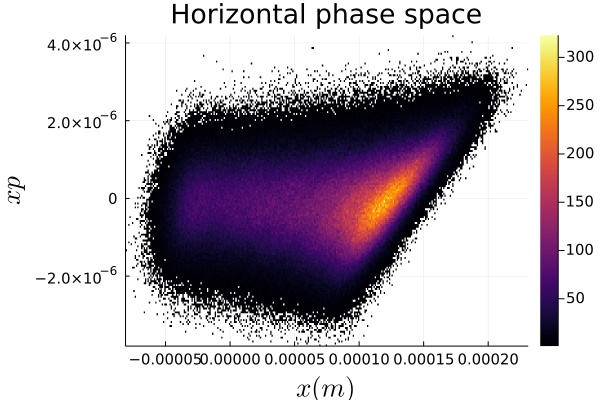

In [47]:
bf = res_chicane["beam_out_B4"]
histogram2d(bf[1,:], bf[2,:], nbins=300)
plot!(xlabel=L"x(m)", ylabel=L"xp", title="Horizontal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

## Plotting results together

In [11]:
CSR2D_dic =load("FACET_chicane_tracking/2DCSRon_10_10_10_steps.jld");
energy_dic = load("FACET_chicane_tracking/energy_kick_only_10_10_10_steps.jld");
xp_dic = load("FACET_chicane_tracking/xp_kick_only_10_10_10_steps.jld");
no_CSR_dic = load("FACET_chicane_tracking/noCSR.jld");

CSR2D_dic_no_exit =load("FACET_chicane_tracking/2DCSRon_no_exit_10_10_10_steps.jld");

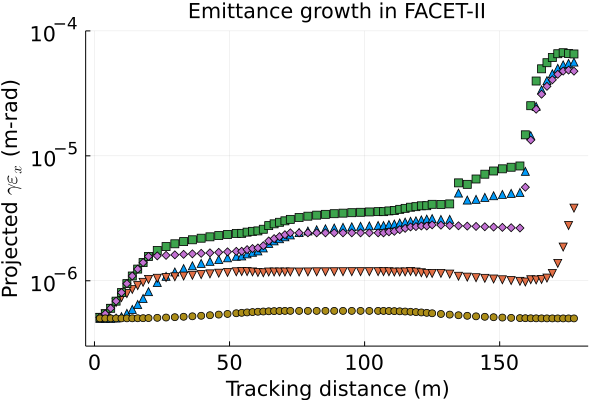

In [12]:
plot(energy_dic[ "s_list"], energy_dic[ "emdf_list"]*gamma, seriestype = :scatter, yaxis=:log, label = "energy kick only", markershape=:utriangle)
plot!(xp_dic[ "s_list"], xp_dic[ "emdf_list"]*gamma, seriestype = :scatter, label = "centripetal kick only", markershape=:dtriangle)
plot!(CSR2D_dic[ "s_list"], CSR2D_dic[ "emdf_list"]*gamma, seriestype = :scatter, yaxis=:log, label="both kicks on", markershape=:rect)
plot!(CSR2D_dic_no_exit[ "s_list"], CSR2D_dic_no_exit[ "emdf_list"]*gamma, seriestype = :scatter, label = "both kicks on (no exit wakes)", markershape=:diamond)

plot!(no_CSR_dic[ "s_list"], no_CSR_dic[ "emdf_list"]*gamma, seriestype = :scatter, label="no CSR", markershape=:circle)

plot!(xlabel="Tracking distance (m)", ylabel="Projected "*L"\gamma \epsilon_x "*" (m-rad)", title="Emittance growth in FACET-II", xtickfontsize=14,ytickfontsize=14)
plot!(xguidefontsize=14, yguidefontsize=14, titlefontsize=14)
plot!(ylim=(3e-7, 1e-4))
#plot!(legend=:outertopleft, legendfontsize = 16)
plot!(legend=false)

# Below is Scratch!!

In [112]:
println("Begin tracking through BEND #2...")

out3 = track_bend_with_2d_csr!(CSR2D_dic["beam_out_D1"], charges, p0c, gamma; L=2.0, rho=rho, 
                            N_step=1, s0=0.9, nz=201, nx=101, nxp=301, M=7, reverse_bend=true,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            bend_name="B2", keep_Pin=false, debug=false, save_all_P=false)

Begin tracking through BEND #2...
Tracking through B2 in the 1th step starting at s= 0.9m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.099903 seconds (112 CPU allocations: 5.438 KiB)
 13.988337 seconds (112 CPU allocations: 5.469 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...


Dict{String, Array} with 7 entries:
  "emit_list"           => Any[3.92771e-9]
  "beam_out"            => [-5.83457e-5 0.00138079 … -0.0029922 0.00049472; 1.6…
  "Wx_list"             => [[1.90027 1.77948 … 3.58313 3.58271; 1.94286 1.82111…
  "s_list"              => Any[2.9]
  "emit_disp_free_list" => Any[4.21027e-11]
  "beam_list"           => Any[]
  "Ws_list"             => [[-4.69088 -4.48139 … 21.3606 21.6182; -3.36969 -3.0…

In [114]:
out5 = track_bend_with_2d_csr!(CSR2D_dic["beam_out_D2"], charges, p0c, gamma; L=2.0, rho=rho, 
                            N_step=1, s0=0.9, nz=201, nx=101, nxp=301, M=7, reverse_bend=true,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, 
                            bend_name="B3", keep_Pin=false, debug=false, save_all_P=false)

Tracking through B3 in the 1th step starting at s= 0.9m
 Applying charge deposition...
 Computing Case A+B wake grid(s) via GPU...
 14.080380 seconds (113 CPU allocations: 5.734 KiB)
 13.986903 seconds (114 CPU allocations: 5.797 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...


Dict{String, Array} with 7 entries:
  "emit_list"           => Any[1.42299e-9]
  "beam_out"            => [2.44191e-5 0.00160016 … -0.00341913 0.000617084; 1.…
  "Wx_list"             => [[1.90027 1.77948 … 3.58313 3.58271; 1.94286 1.82111…
  "s_list"              => Any[2.9]
  "emit_disp_free_list" => Any[4.58266e-11]
  "beam_list"           => Any[]
  "Ws_list"             => [[-4.69088 -4.48139 … 21.3606 21.6182; -3.36969 -3.0…

In [92]:
save("BC2_chicane_tracking/noCSR.jld", res_chicane)

In [93]:
lala2 = load("BC2_chicane_tracking/noCSR.jld");

In [40]:
save("BC2_chicane_tracking/CSRon_10_10_4_steps.jld", res_chicane)

In [24]:
lala = load("BC2_chicane_tracking/10_10_4_steps.jld");

Dict{String, Any} with 16 entries:
  "Ws_list_B2"  => [[-77.9737 -72.5594 … 216.133 219.274; -80.1589 -74.6167 … 2…
  "Ws_list_B4"  => [[-77.9737 -72.5594 … 216.133 219.274; -80.1589 -74.6167 … 2…
  "Ws_list_B1"  => [[-77.9737 -72.5594 … 216.133 219.274; -80.1589 -74.6167 … 2…
  "em_list"     => Any[2.55866e-10, 2.55861e-10, 2.55854e-10, 2.55861e-10, 2.55…
  "beam_out_D2" => [0.00314123 -0.00032509 … -0.00194833 -0.00205376; 0.0004955…
  "beam_out_D3" => [0.0105457 -0.000799654 … -0.00584571 -0.00613182; 0.0007200…
  "s_list"      => Any[0.0549201, 0.10984, 0.16476, 0.21968, 0.2746, 0.329521, …
  "Ws_list_D1"  => [[-0.353131 -0.347066 … -1.16592 -1.18968; -1.12396 -1.12606…
  "Ws_list_D4"  => [[-0.353131 -0.347066 … -1.16592 -1.18968; -1.12396 -1.12606…
  "Ws_list_D2"  => [[-0.839712 -0.821453 … -3.10376 -3.07418; -1.97133 -1.98201…
  "beam_out_B1" => [-0.000546207 -0.000156508 … -0.000145059 -0.00017212; 0.000…
  "Ws_list_B3"  => [[-77.9737 -72.5594 … 216.133 219.274; -80.1589 -74.616

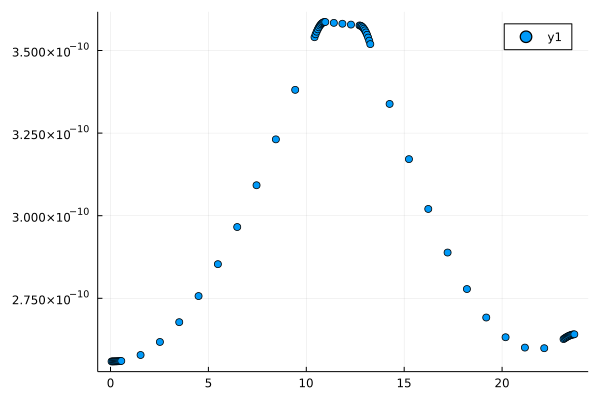

In [95]:
#plot(lala[ "s_list"],lala[ "em_list"], seriestype = :scatter)
plot(lala2[ "s_list"],lala2[ "emdf_list"], seriestype = :scatter)

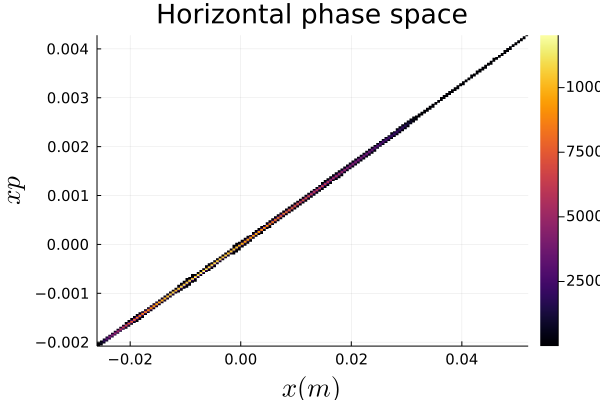

In [35]:
bf = res_chicane["beam_out_B4"]
histogram2d(bf[1,:], bf[2,:], nbins=300)
plot!(xlabel=L"x(m)", ylabel=L"xp", title="Horizontal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

### Testing

In [60]:
@time result = track_bend_with_2d_csr!(bb, charges, p0c, gamma; L=0.20, rho=0.5, 
                            N_step=1, s0=0.0, nz=201, nx=101, nxp=301, M=7,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true);

Tracking through the bend in the 1th step starting at s= 0.0m


LoadError: BoundsError: attempt to access 6×1999968 adjoint(::Matrix{Float64}) with eltype Float64 at index [1:6, 1999969]

In [46]:
@time result = track_drift_with_2d_csr!(bb, charges, p0c, gamma; L=0.005, rho=1.5, phi_m=0.2, 
                            N_step=1, s0=0.0, nz=201, nx=101, nxp=301, M=7,
                            CSR_on=true, energy_kick_on=true, xp_kick_on=true);

Tracking through the drift in the 1th step starting at s= 0.0m
 Applying charge deposition...
 Computing Case C+D+E wake grid(s) via GPU...
 12.908550 seconds (64 CPU allocations: 3.625 KiB)
 12.814604 seconds (65 CPU allocations: 3.688 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
 36.718522 seconds (270.83 M allocations: 9.138 GiB, 5.19% gc time, 0.68% compilation time)


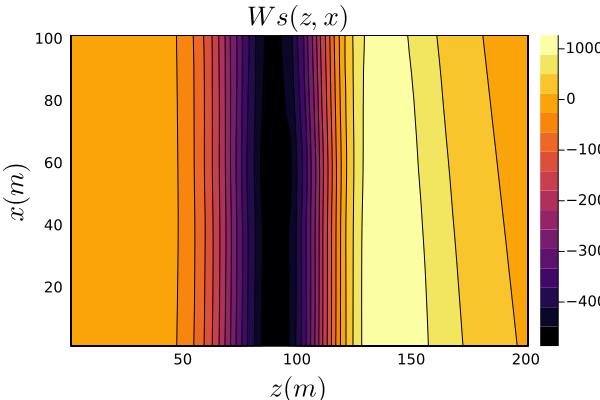

In [91]:
kaka = contourf(result["Ws_list"][1]', legendfont= font(8))
plot!(xlabel=L"z(m)", ylabel=L"x(m)", title=L"Ws(z,x)", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

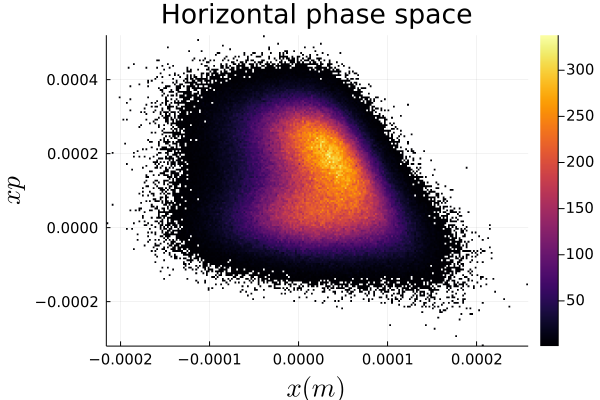

In [134]:
bf = result["beam_list"][5]
histogram2d(bf[1,:], bf[2,:], nbins=300)
plot!(xlabel=L"x(m)", ylabel=L"xp", title="Horizontal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

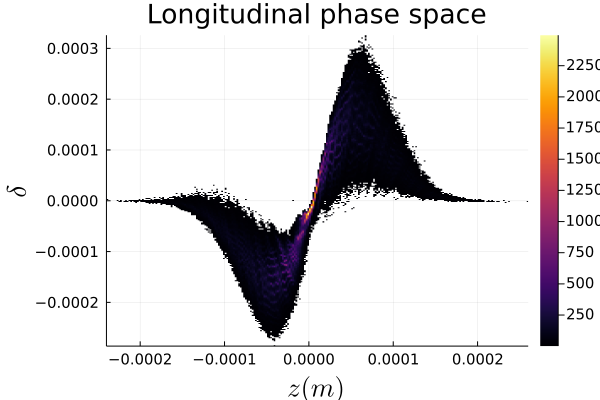

In [108]:
bf = result["beam_list"][2]
histogram2d(bf[5,:], bf[6,:], nbins=300)
plot!(xlabel=L"z(m)", ylabel=L"\delta", title="Longitudinal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

In [64]:
#both_on = result["emit_disp_free_list"]
#energy_kick_only = result["emit_disp_free_list"]
#xp_kick_only = result["emit_disp_free_list"]
#no_csr = result["emit_disp_free_list"]

In [77]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_xp_kick_only.dat", xp_kick_only)

In [78]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_no_CSR.dat", no_csr)

In [79]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_energy_kick_only .dat", energy_kick_only )

In [80]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_CSR_all_on.dat", both_on)

In [19]:
using DelimitedFiles

In [42]:
#writedlm("one_bend_data/s_list.dat", result["s_list"])
#writedlm("one_bend_data/emit_disp_free_list_CSR_all_on.dat", result["emit_disp_free_list"])

writedlm("one_bend_data/emit_disp_free_list_xp_kick_only.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/emit_disp_free_list_energy_kick_only.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/emit_disp_free_list_no_CSR.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/bf_CSR_all_on.dat", result["bf"])

In [69]:
writedlm("one_bend_data/bf_CSR_all_on_rho_05_L_06.dat", result["bf"])

In [15]:
gaga = readdlm("one_bend_data/bf_CSR_all_on_rho_05_L_06.dat");

In [44]:
haha = readdlm("one_bend_data/emit_disp_free_list_CSR_all_on.dat");
haha2 = readdlm("one_bend_data/emit_disp_free_list_energy_kick_only.dat");
haha3 = readdlm("one_bend_data/emit_disp_free_list_xp_kick_only.dat");
haha4 = readdlm("one_bend_data/emit_disp_free_list_no_CSR.dat");

In [ ]:
#both_on = result["emit_disp_free_list"]
#energy_kick_only = result["emit_disp_free_list"]
#xp_kick_only = result["emit_disp_free_list"]
#no_csr = result["emit_disp_free_list"]

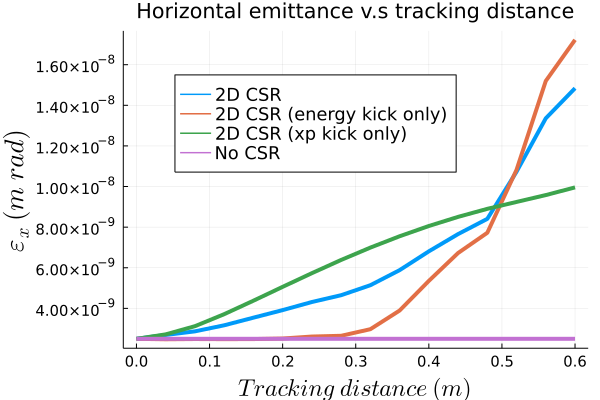

In [76]:
plot(result["s_list"], both_on, label="2D CSR", linewidth = 4)
plot!(result["s_list"], energy_kick_only , label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"],xp_kick_only, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"],no_csr, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x~ (m~rad)", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=12)

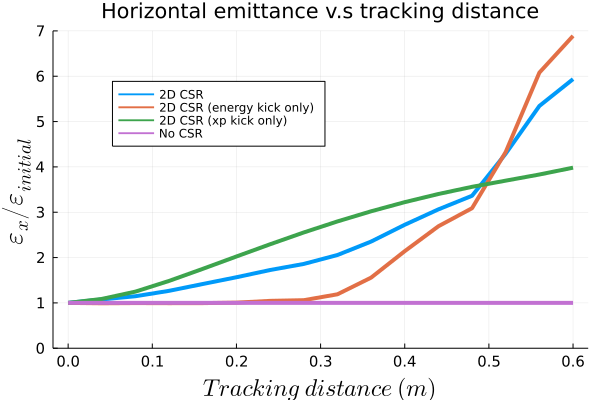

In [86]:
plot(result["s_list"], both_on./ no_csr, label="2D CSR", linewidth = 4)
plot!(result["s_list"], energy_kick_only./ no_csr , label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"],xp_kick_only./ no_csr, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"],no_csr ./ no_csr, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x/\epsilon_{initial}", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=15)
ylims!((0,7))

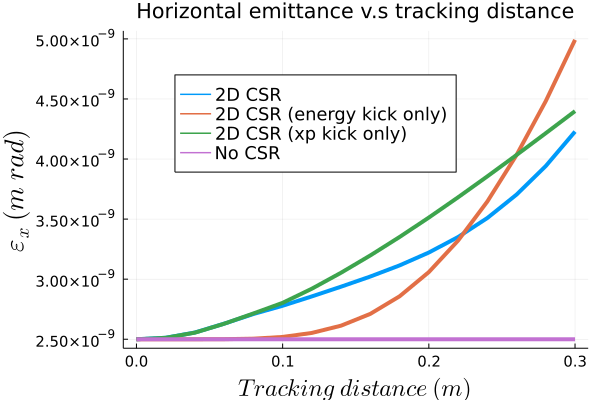

In [72]:
#plot(result["s_list"], result["emit_list"])
plot(result["s_list"], haha, label="2D CSR", linewidth = 4)
plot!(result["s_list"], haha2, label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"], haha3, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"], haha4, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x~ (m~rad)", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=12)

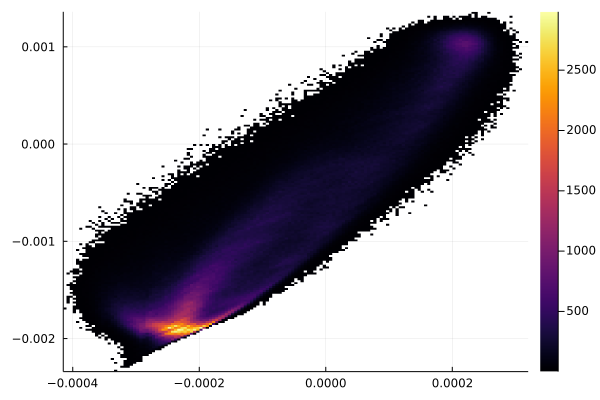

In [66]:
bf = result["bf"]
histogram2d(bf[1,:], bf[2,:], nbins=300)

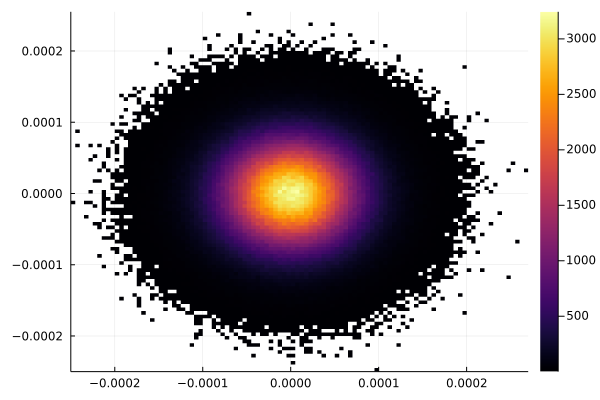

In [158]:
histogram2d(bb[1,:], bb[2,:], nbins=100)

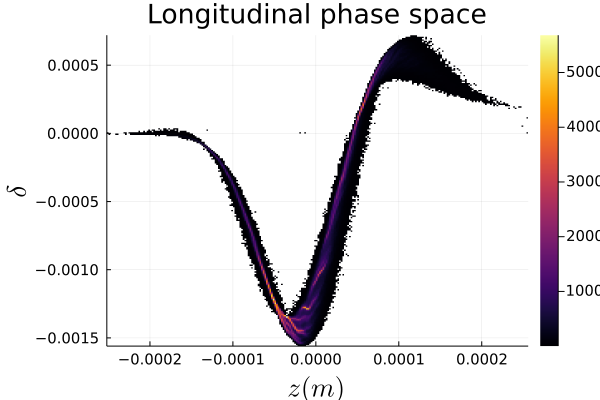

In [34]:
#bf = result["bf"]
histogram2d(gaga[5,:], gaga[6,:], nbins=300, xlabel=L"z(m)", ylabel=L"\delta", title="Longitudinal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

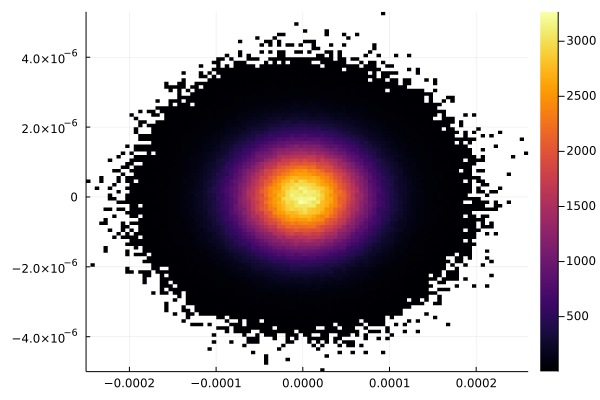

In [14]:
histogram2d(bb[5,:], bb[6,:], nbins=100)

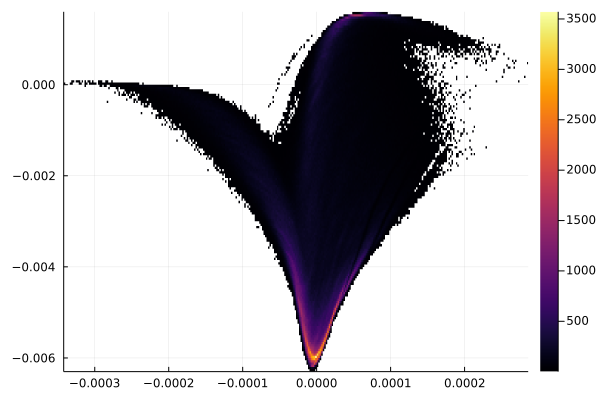

In [68]:
bf = result["bf"]
histogram2d(bf[5,:], bf[6,:], nbins=300)